# GAN with fashion-MNIST
- https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Dropout
import tensorflow as tf
from tensorflow import keras

(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


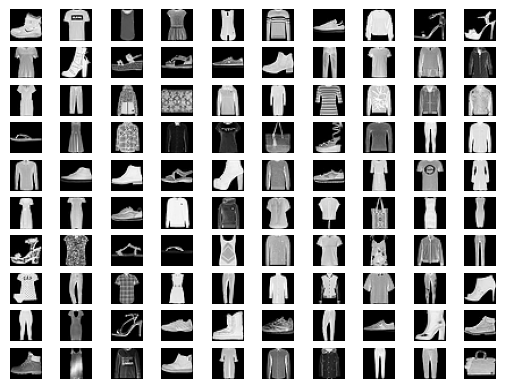

In [3]:
for i in range(100):
	plt.subplot(10, 10, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i], cmap='gray')  # cmap = gray or gray_r
plt.show()

In [4]:
set(trainy)

{np.uint8(0),
 np.uint8(1),
 np.uint8(2),
 np.uint8(3),
 np.uint8(4),
 np.uint8(5),
 np.uint8(6),
 np.uint8(7),
 np.uint8(8),
 np.uint8(9)}

## Unconditional GAN

In [5]:
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Input(shape=in_shape))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,137 (606.00 KB)

 Trainable params: 155,137 (606.00 KB)

 Non-trainable params: 0 (0.00 B)

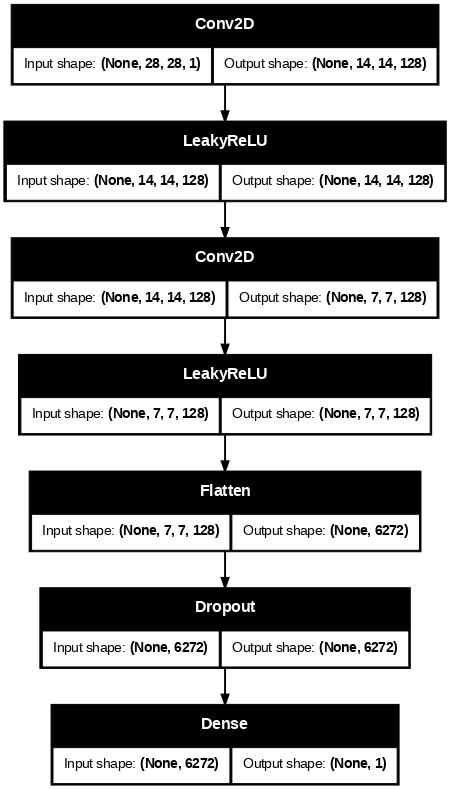

In [6]:
define_discriminator().summary()
keras.utils.plot_model(define_discriminator(), "gan_encoder.png", show_shapes=True, dpi=70)

- not compiled yet (intentionally), and returns the model

In [7]:
# take as input a point in the latent space and outputs a single 28x28 grayscale image
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Input(shape=(latent_dim,)))                   # 7*7 -> 14*14 -> 28*28 upsampling 하기 위해
	model.add(Dense(n_nodes))                            # 7x7x128 크기의 feature map 으로 변환
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # upsample to 14x14
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # upsample to 28x28
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))        # generate
	return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 6272)           │       633,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,164,289 (4.44 MB)

 Trainable params: 1,164,289 (4.44 MB)

 Non-trainable params: 0 (0.00 B)

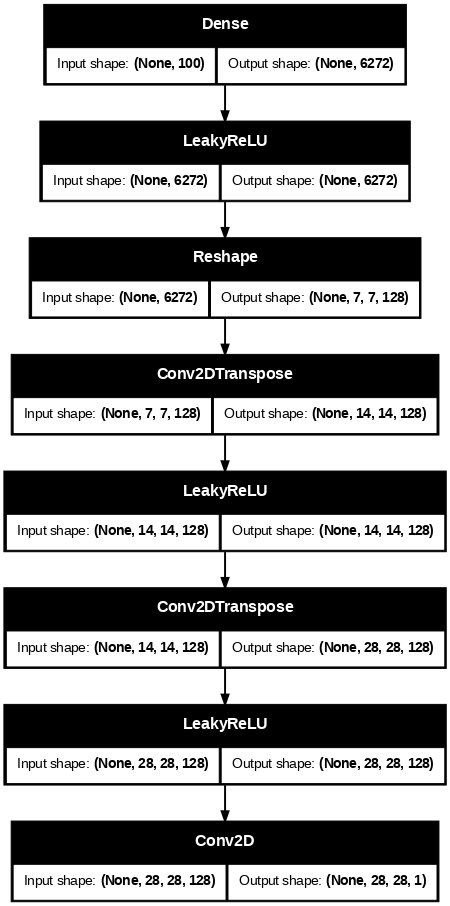

In [8]:
latent_dim = 100
define_generator(latent_dim).summary()
keras.utils.plot_model(define_generator(latent_dim), "gan_decoder.png", show_shapes=True, dpi=70)

In [9]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 28, 28, 1)      │     1,164,289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 1)              │       155,137 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,319,426 (5.03 MB)

 Trainable params: 1,164,289 (4.44 MB)

 Non-trainable params: 155,137 (606.00 KB)

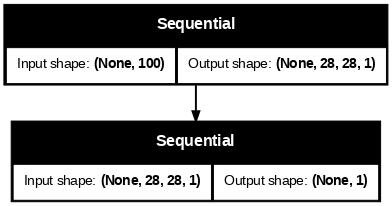

In [10]:
all = define_gan(define_generator(100), define_discriminator())
all.summary()
keras.utils.plot_model(all, "all.png", show_shapes=True, dpi=70)

In [11]:
# load fashion mnist images
def load_real_samples():
	(trainX, _), (_, _) = fashion_mnist.load_data()
	X = np.expand_dims(trainX, axis=-1)   # expand to 3d, e.g. add channels (60000,28,28,1)
	X = X.astype('float32')               # convert from ints to floats
	X = (X - 127.5) / 127.5               # scale from [0,255] to [-1,1]
	return X

- We will require one batch (or a half) batch of real images from the dataset each update to the GAN model. A simple way to achieve this is to select a random sample of images from the dataset each time.

In [12]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = np.ones((n_samples, 1))   # y_real = 1
	return X, y

- Next, we need inputs for the generator model. These are random points from the latent space, specifically Gaussian distributed random variables.

In [13]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

- Next, we need to use the points in the latent space as input to the generator in order to generate new images.

In [14]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = np.zeros((n_samples, 1))  # y_fake = 0
	return X, y

- We are now ready to fit the GAN models.

- train_on_batch: runs a single gradient update on a single batch of data

In [15]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):   # n_epochs=100
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)

	for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)  # batch-wise fit

			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = np.ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # loss for the discriminator on real and fake, and loss for the generator
			print('>epoch:%d, batch:%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

	g_model.save('generator.h5')

In [ ]:
latent_dim = 100

discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)

dataset = load_real_samples()

train(generator, discriminator, gan_model, dataset, latent_dim)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Streaming output truncated to the last 5000 lines.
>epoch:5, batch:308/468, d1=1.110, d2=1.110 g=0.253
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>epoch:5, batch:309/468, d1=1.110, d2=1.110 g=0.252
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
>epoch:5, batch:310/468, d1=1.110, d2=1.110 g=0.252
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>epoch:5, batch:311/468, d1=1.110, d2=1.110 g=0.252
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
>epoch:5, batch:312/468, d1=1.110, d2=1.111 g=0.252
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
>epoch:5, batch:313/468, d1=1.110, d2=1.111 g=0.252
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
>epoch:5, batch:314/468, d1=1.110, d2=1.111 g=0.252
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>epoch:5, batch:315/468, d1=1.111, d2=1.111 g=0.252
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
>epoch:5, batch:316/468, d1=1.111, d2=1.111 g=0.252
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
>epoch:5, batch:317/468, d1=1.111, d2=1.111 g=0.252
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>epoch:5, batch:318/468, d1=1.111, d2=1.111 g=0.2

>epoch:10, batch:468/468, d1=1.162, d2=1.162 g=0.224


- now, we generate 100 random items of clothing

In [ ]:
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
    plt.figure(figsize=(12,12))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)    # define subplot
        plt.axis('off')             # turn off axis
        plt.imshow(examples[i, :, :, 0], cmap='gray')
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


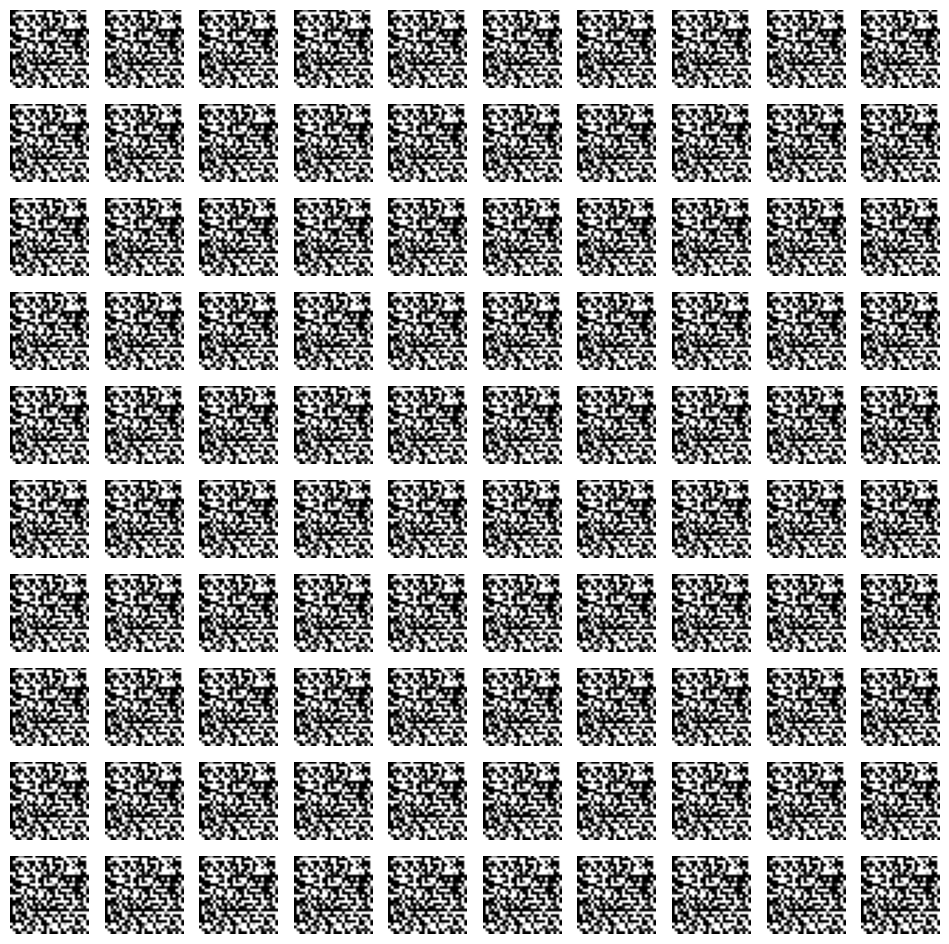

In [ ]:
# load model
model = keras.models.load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 10)